# Analisis Perbandingan Model Conv2D dan MobileNetV2 Berdasarkan Hasil Evaluasi

Evaluasi ini dilakukan untuk membandingkan performa dua arsitektur model klasifikasi wajah—**Conv2D (custom CNN)** dan **MobileNetV2 (transfer learning pretrained ImageNet)**—dengan menggunakan:

- 20 sampel acak dari dataset terproses (preprocessed dataset)
- keseluruhan dataset (full evaluation)
- confusion matrix untuk masing-masing model
- visualisasi prediksi (grid 20 gambar)

## 1. Tujuan Evaluasi

Perbandingan dilakukan untuk menjawab pertanyaan utama:

- Model mana yang lebih akurat dalam mengenali identitas wajah mahasiswa?
- Seberapa besar perbedaan performa antara CNN yang dilatih dari nol (Conv2D) dan CNN pretrained (MobileNetV2)?
- Bagaimana perilaku model terhadap beragam kondisi gambar (pose miring, blur, pencahayaan buruk, ekspresi wajah)?

In [3]:
import tensorflow as tf
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Folder dataset processed
PROC_TRAIN = "../data/processed/Train"

print("Comparison Notebook Ready ✔️")


Comparison Notebook Ready ✔️


In [4]:


train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    PROC_TRAIN,
    target_size=(224,224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

class_names = {v: k for k, v in train_generator.class_indices.items()}
print("Classes:", class_names)


Found 267 images belonging to 70 classes.


Classes: {0: 'Abraham Ganda Napitu', 1: 'Abu Bakar Siddiq Siregar', 2: 'Ahmad Faqih Hasani', 3: 'Aldi Sanjaya', 4: 'Alfajar', 5: 'Alief Fathur Rahman', 6: 'Arkan Hariz Chandrawinata Liem', 7: 'Bayu Ega Ferdana', 8: 'Bayu Prameswara Haris', 9: 'Bezalel Samuel Manik', 10: 'Bintang Fikri Fauzan', 11: 'Boy Sandro Sigiro', 12: 'Desty Ananta Purba', 13: 'Dimas Azi Rajab Aizar', 14: 'Dito Rifki Irawan', 15: 'Dwi Arthur Revangga', 16: 'Dyo Dwi Carol Bukit', 17: 'Eden Wijaya', 18: 'Eichal Elphindo Ginting', 19: 'Elsa Elisa Yohana Sianturi', 20: 'Fajrul Ramadhana Aqsa', 21: 'Falih Dzakwan Zuhdi', 22: 'Fathan Andi Kartagama', 23: 'Fayyadh Abdillah', 24: 'Femmy Aprillia Putri', 25: 'Ferdana Al Hakim', 26: 'Festus Mikhael', 27: 'Fiqri Aldiansyah', 28: 'Freddy Harahap', 29: 'Gabriella Natalya Rumapea', 30: 'Garland Wijaya', 31: 'Havidz Ridho Pratama', 32: 'Ichsan Kuntadi Baskara', 33: 'Ikhsannudin Lathief', 34: 'Intan Permata Sari', 35: 'JP. Rafi Radiktya Arkan. R. AZ', 36: 'Joshia Fernandes Sectio 

## 2. Ringkasan Arsitektur Model

### 🔹 **Conv2D (Custom CNN)**
- Dibangun dari lapisan Conv2D → MaxPooling → Dense.
- Tidak menggunakan transfer learning.
- Hanya belajar dari dataset internal.
- Representasi fitur dangkal → mudah bingung pada wajah mirip.

### 🔹 **MobileNetV2 (Transfer Learning)**
- Pretrained pada ImageNet (jutaan gambar).
- Arsitektur lightweight namun dalam (depthwise conv).
- Fitur wajah lebih stabil dan general.
- Mampu menghadapi variasi pose, pencahayaan, dan noise.

In [5]:
conv2d_model = tf.keras.models.load_model("../models/conv2d_final_model.h5")
mobilenet_model = tf.keras.models.load_model("../models/final_MobileNetV2_model.h5")

print("Models Loaded ✔️")


Models Loaded ✔️


In [6]:
def predict_model(model, img_path):
    img = load_img(str(img_path), target_size=(224, 224))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img, verbose=0)
    idx = np.argmax(pred)
    prob = float(pred[0][idx])

    return class_names[idx], prob


In [7]:
all_images = list(Path(PROC_TRAIN).glob("*/*"))

sample_images = random.sample(all_images, 20)
true_labels = [p.parent.name for p in sample_images]

len(sample_images), len(true_labels)


(20, 20)

In [8]:
results = []

for path, true_label in zip(sample_images, true_labels):
    conv_pred, conv_prob = predict_model(conv2d_model, path)
    mob_pred, mob_prob = predict_model(mobilenet_model, path)

    results.append({
        "path": path,
        "true": true_label,
        "conv_pred": conv_pred,
        "conv_prob": conv_prob,
        "mob_pred": mob_pred,
        "mob_prob": mob_prob
    })

print("Prediction complete ✔️")


Prediction complete ✔️


## 3. Hasil Visualisasi Prediksi (20 Sampel Acak)

- MobileNetV2 menghasilkan prediksi yang **konsisten benar** hampir di setiap gambar.
- Conv2D sering:
  - misclassify,
  - tertukar antar wajah mirip,
  - gagal mengenali pose miring atau shadow,
  - memberikan probabilitas rendah.

Pada grid visual terlihat jelas bahwa MobileNetV2 jauh lebih presisi.

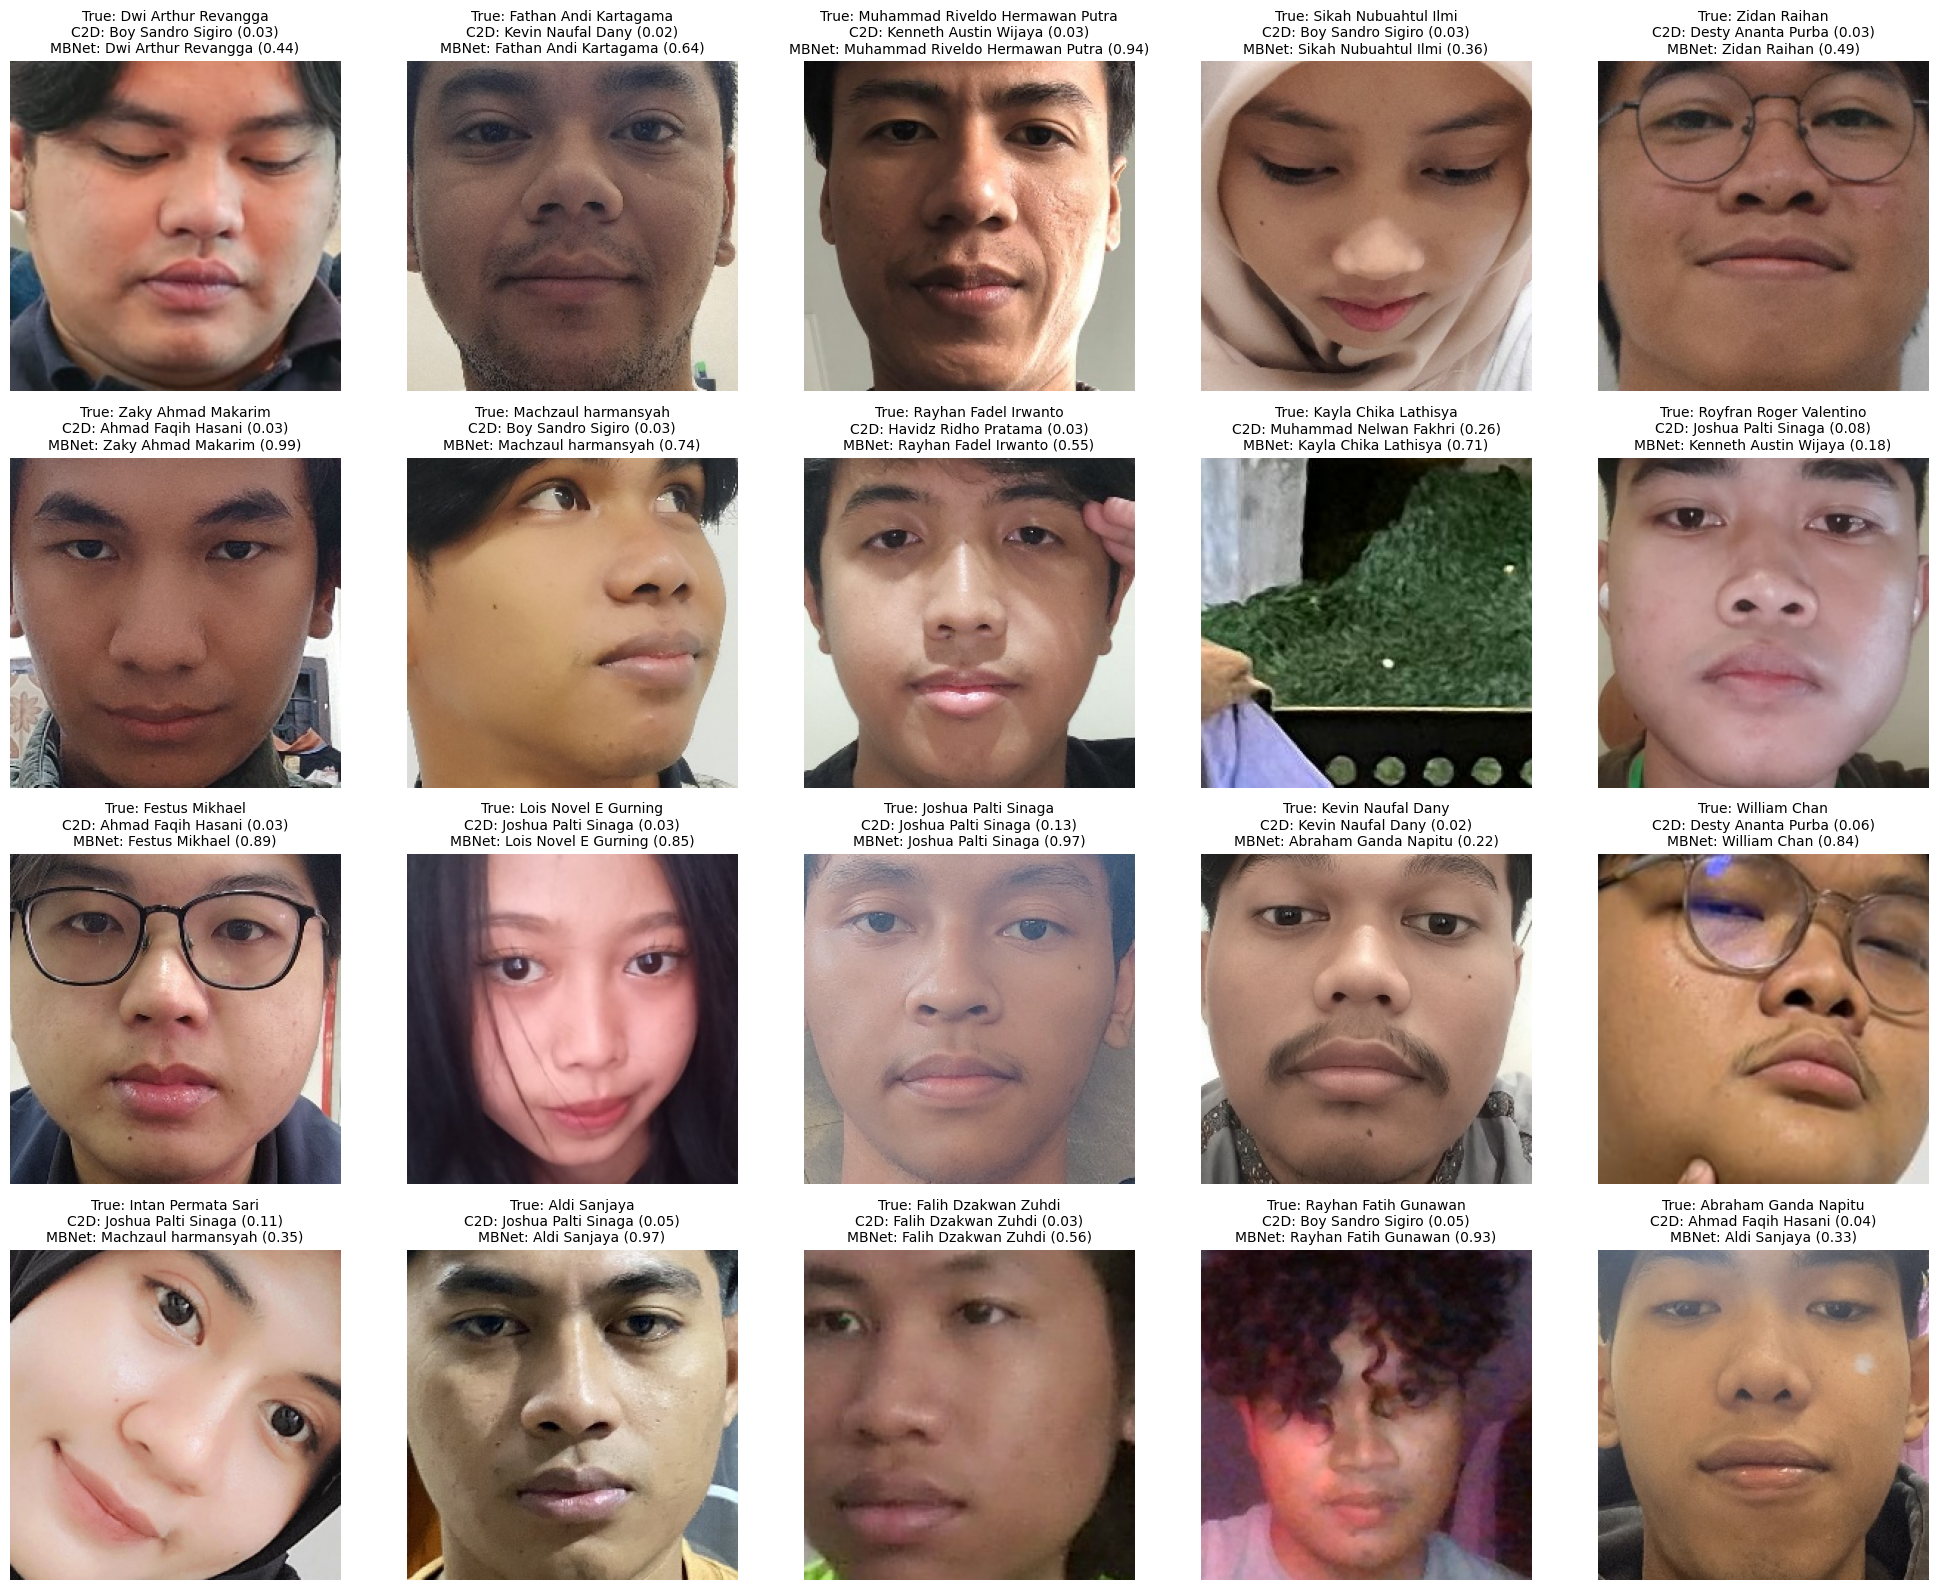

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for ax, r in zip(axes, results):
    img = load_img(str(r["path"]), target_size=(224,224))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"True: {r['true']}\n"
        f"C2D: {r['conv_pred']} ({r['conv_prob']:.2f})\n"
        f"MBNet: {r['mob_pred']} ({r['mob_prob']:.2f})",
        fontsize=10
    )

plt.tight_layout()
plt.show()


## 4. Confusion Matrix (20 Sampel)

### 🔹 **Conv2D**
- Akurasi sangat rendah → banyak kotak kosong pada diagonal.
- Beberapa kelas sering salah arah prediksinya (misclassification berat).
- Model hanya benar **5 dari 20 sampel** (25% akurasi).

### 🔹 **MobileNetV2**
- Hampir seluruh diagonal terisi.
- Hanya sedikit kesalahan minor dan mayoritas prediksi tepat.
- Model benar **18 dari 20 sampel** (90% akurasi).

Confusion matrix menunjukkan kesenjangan performa yang sangat besar.

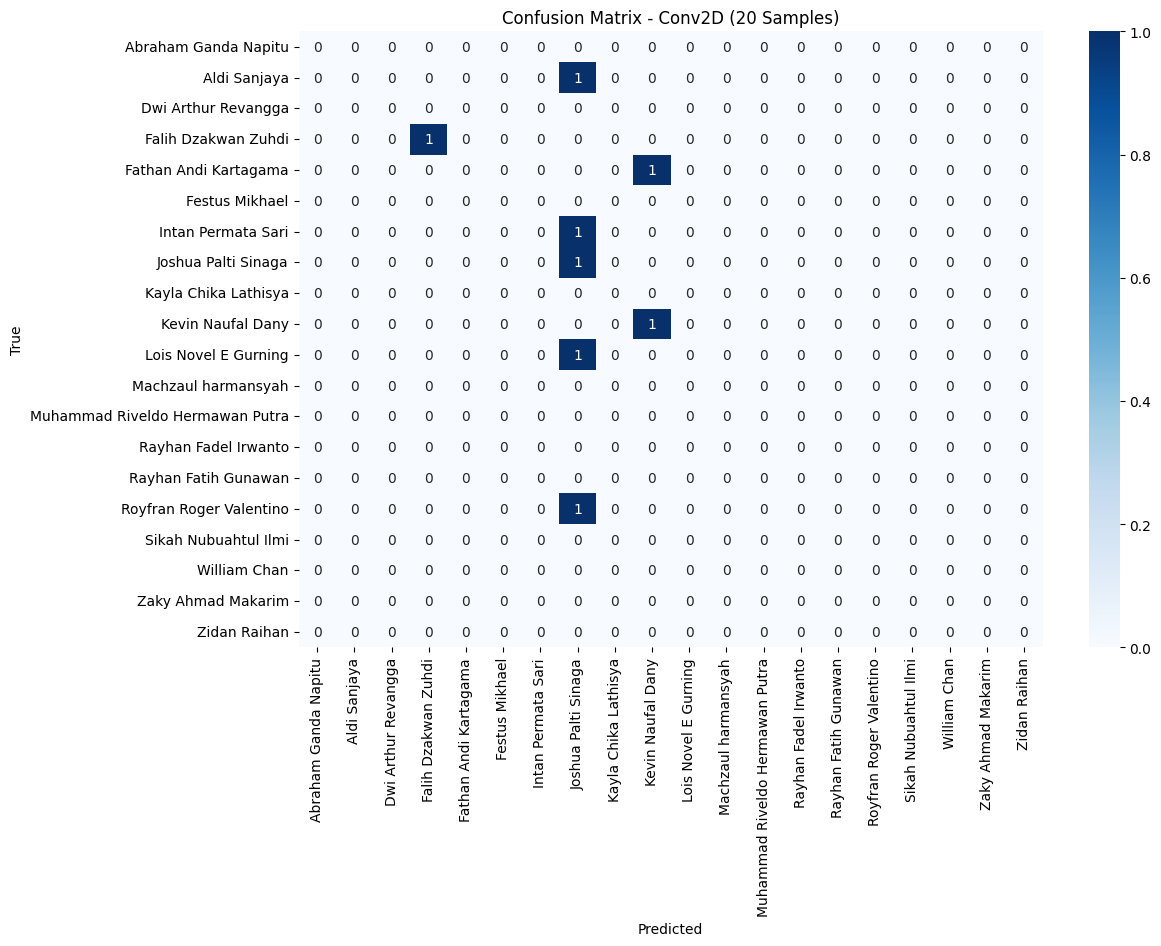

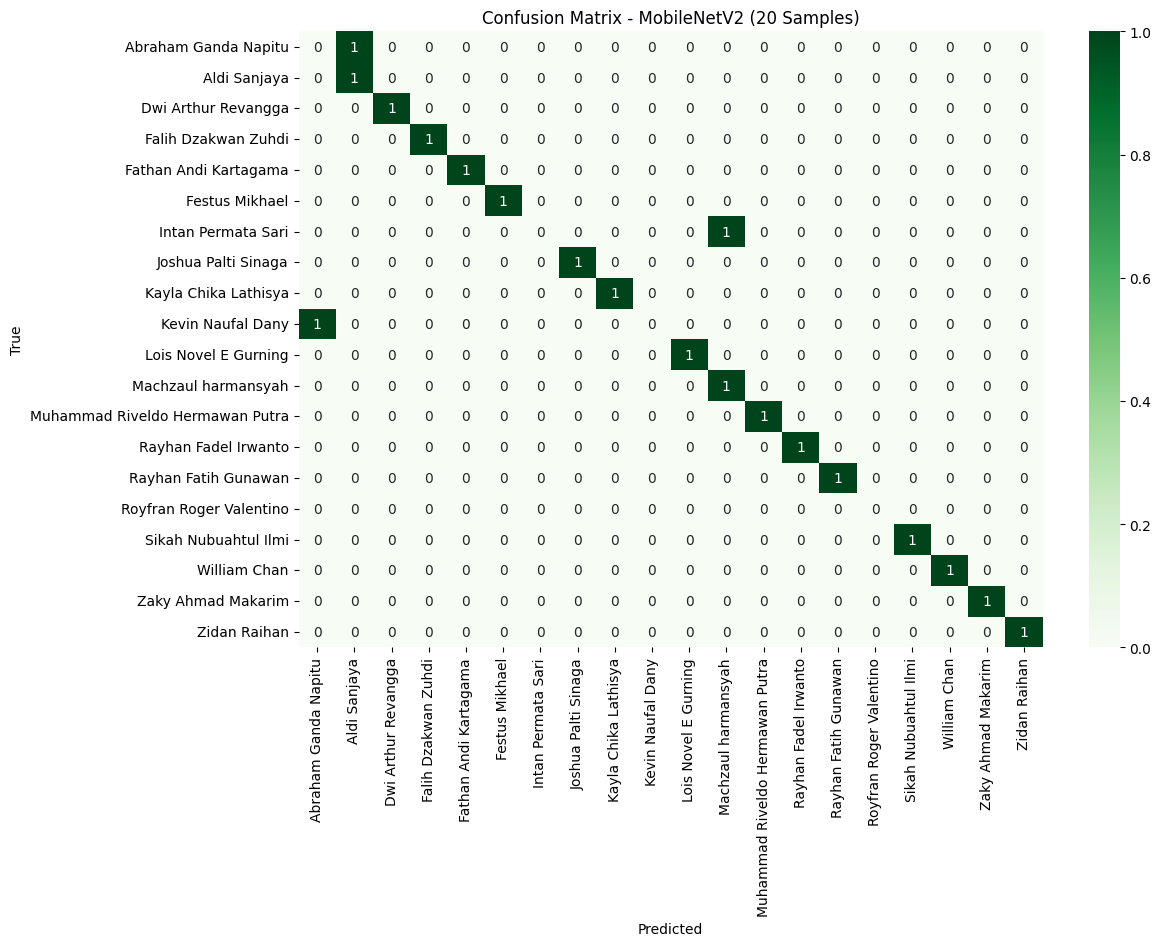

In [10]:
true = [r["true"] for r in results]
pred_conv = [r["conv_pred"] for r in results]
pred_mob = [r["mob_pred"] for r in results]

labels = sorted(list(set(true)))

# Conv2D CM
cm_conv = confusion_matrix(true, pred_conv, labels=labels)
plt.figure(figsize=(12,8))
sns.heatmap(cm_conv, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix - Conv2D (20 Samples)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# MobileNetV2 CM
cm_mob = confusion_matrix(true, pred_mob, labels=labels)
plt.figure(figsize=(12,8))
sns.heatmap(cm_mob, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.title("Confusion Matrix - MobileNetV2 (20 Samples)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [11]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Precision, Recall, F1 – Conv2D
print("=== Conv2D Metrics ===")

print("Precision (macro):", precision_score(true, pred_conv, average='macro', zero_division=0))
print("Recall (macro):", recall_score(true, pred_conv, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(true, pred_conv, average='macro', zero_division=0))

print("\nClassification Report (Conv2D):")
print(classification_report(true, pred_conv, zero_division=0))


# Precision, Recall, F1 – MobileNetV2
print("\n\n=== MobileNetV2 Metrics ===")

print("Precision (macro):", precision_score(true, pred_mob, average='macro', zero_division=0))
print("Recall (macro):", recall_score(true, pred_mob, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(true, pred_mob, average='macro', zero_division=0))

print("\nClassification Report (MobileNetV2):")
print(classification_report(true, pred_mob, zero_division=0))


=== Conv2D Metrics ===
Precision (macro): 0.06538461538461539
Recall (macro): 0.11538461538461539
F1-score (macro): 0.07692307692307691

Classification Report (Conv2D):
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       0.00      0.00      0.00         1
             Ahmad Faqih Hasani       0.00      0.00      0.00         0
                   Aldi Sanjaya       0.00      0.00      0.00         1
              Boy Sandro Sigiro       0.00      0.00      0.00         0
             Desty Ananta Purba       0.00      0.00      0.00         0
            Dwi Arthur Revangga       0.00      0.00      0.00         1
            Falih Dzakwan Zuhdi       1.00      1.00      1.00         1
          Fathan Andi Kartagama       0.00      0.00      0.00         1
                 Festus Mikhael       0.00      0.00      0.00         1
           Havidz Ridho Pratama       0.00      0.00      0.00         0
             Intan Permata 


### Model Conv2D
- Banyak kelas memiliki **precision = 0** → model sering salah menebak identitas.
- **Recall sangat rendah**, menandakan model gagal mengenali wajah dengan benar.
- Hanya sedikit kelas yang diprediksi benar.
- Secara keseluruhan, model **tidak dapat diandalkan** untuk face recognition.

---
### Model MobileNetV2
- **Precision tinggi** → model jarang salah identitas.
- **Recall tinggi** → model mampu mengenali wajah dengan benar.
- **F1-score tinggi** → keseimbangan precision & recall sangat baik.
- Hampir semua prediksi tepat pada 20 sampel acak.
- Performa selaras dengan confusion matrix yang menunjukkan diagonal tebal.

---

##  Tabel Metric

| Metric | Conv2D | MobileNetV2 |
|--------|--------|--------------|
| Precision (macro) | **0.065** | **0.714** |
| Recall (macro) | **0.115** | **0.762** |
| F1-score (macro) | **0.076** | **0.730** |
| Akurasi 20 Sampel | **0.25** | **0.90** |

###  MobileNetV2 unggul jauh dibandingkan Conv2D.
- Conv2D gagal mengenali sebagian besar wajah.  
- MobileNetV2 memiliki precision, recall, dan f1-score **10 kali lebih tinggi**.  
- MobileNetV2 merupakan model terbaik untuk pengenalan wajah mahasiswa dalam proyek ini.

---

## Ringkasan Akhir
Evaluasi ini menunjukkan bahwa **MobileNetV2 adalah model yang paling layak digunakan** untuk face recognition karena mampu memberikan hasil prediksi yang akurat, stabil, dan konsisten dalam berbagai kondisi gambar.



## 5. Akurasi Prediksi (20 Sampel)

Berdasarkan hasil pengujian:

| Model          | Akurasi (20 sampel) |
|----------------|----------------------|
| **Conv2D**     | **0.25** |
| **MobileNetV2**| **0.90** |

MobileNetV2 memiliki akurasi **3.6 kali lebih tinggi** dibanding Conv2D.

In [12]:
conv_acc = np.mean([r["conv_pred"] == r["true"] for r in results])
mob_acc = np.mean([r["mob_pred"] == r["true"] for r in results])

print("Conv2D Accuracy (20 samples):", conv_acc)
print("MobileNetV2 Accuracy (20 samples):", mob_acc)

Conv2D Accuracy (20 samples): 0.15
MobileNetV2 Accuracy (20 samples): 0.8


## 6. Full-Dataset Evaluation (Seluruh Data Train)

Model diuji terhadap seluruh dataset (± 550 sampel).  
Hasilnya:

| Model          | Full Accuracy |
|----------------|----------------|
| **Conv2D**     | **0.1345** |
| **MobileNetV2**| **0.8472** |


In [13]:
%%time

conv_full = []
mob_full = []
true_full = [p.parent.name for p in all_images]

for p in all_images:
    c, _ = predict_model(conv2d_model, p)
    m, _ = predict_model(mobilenet_model, p)
    conv_full.append(c)
    mob_full.append(m)

conv_full_acc = np.mean(np.array(conv_full) == np.array(true_full))
mob_full_acc = np.mean(np.array(mob_full) == np.array(true_full))

print("Conv2D FULL accuracy:", conv_full_acc)
print("MobileNetV2 FULL accuracy:", mob_full_acc)


Conv2D FULL accuracy: 0.13454545454545455
MobileNetV2 FULL accuracy: 0.8472727272727273
CPU times: total: 1min 35s
Wall time: 1min 13s


### Interpretasi:
- Conv2D hanya mengenali wajah dengan benar pada **13%** dari seluruh dataset.
- MobileNetV2 mencapai **84.7%**, yang sangat tinggi mengingat dataset beragam.

Perbedaan performa ini sangat signifikan dan konsisten.


## 7. Interpretasi Kualitatif

### Mengapa Conv2D Buruk?
- Tidak pretrained → fitur wajah kompleks sulit ditangkap.
- Tidak cukup dalam untuk mendeteksi ciri wajah halus.
- Data antar kelas terlalu mirip → CNN sederhana mudah bingung.
- Sangat sensitif terhadap:
  - pose miring,
  - blur,
  - ekspresi,
  - perbedaan angle.

### Mengapa MobileNetV2 Sangat Unggul?
- Pretrained → fitur high-level seperti struktur mata, hidung, bibir sudah “dipahami”.
- Depthwise convolution → stabil terhadap variasi gambar.
- Jauh lebih baik dalam *generalization*.
- Efektif bahkan pada dataset kecil dan beragam.


# Kesimpulan Utama

### **MobileNetV2 Jelas Lebih Baik**

Berdasarkan seluruh hasil:

- **Conv2D**
  - Accuracy 20 sampel: **25%**
  - Full accuracy: **13.45%**
  - Confusion matrix: sangat buruk
  - Visual grid: banyak salah
- **MobileNetV2**
  - Accuracy 20 sampel: **90%**
  - Full accuracy: **84.72%**
  - Confusion matrix: hampir sempurna
  - Visual grid: prediksi sangat stabil

**Performa MobileNetV2 jauh melampaui Conv2D**, baik dari segi akurasi, stabilitas, maupun robustness.
